In [ ]:
import csv
import cv2
import numpy as np
import sklearn
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers.core import Dense, Flatten, Activation, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import ELU
import math
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

In [3]:
samples = []
csv_path = ['data/data/driving_log.csv', 'data/ds1/driving_log.csv', 'data/DSReverse/driving_log.csv']
for j in range(3):
    with open(csv_path[j]) as csvfile:
        #csvlines = csvfile.readlines()  # if we use this method then comment below 3 lines and replace samples by csvlines
        reader = csv.reader(csvfile)
        for line in reader:
             # skip it if ~0 speed - not representative of driving behavior
            if float(line[6]) < 0.1 :
                continue
            if float(line[3])>0.01 or float(line[3])<-0.01:
                samples.append(line)
            else:
                select_prob = np.random.random()
                if select_prob > 0.8:
                    samples.append(line)
                
            #samples.append(line)
        
print(len(samples))
a= np.array(samples)

6070


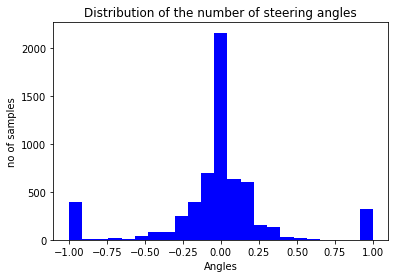

In [4]:
plt.hist(a[:,3].astype(np.float), color = 'b', label = 'train', normed = False, bins=23)
plt.title('Distribution of the number of steering angles')
plt.xlabel('Angles')
plt.ylabel('no of samples')
plt.show()

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ] [ 398    3    9   15   16   16   64   66  135  231  368  716 2014  643  664
  138  154   48   35    6    8    2    0    1  320    1]


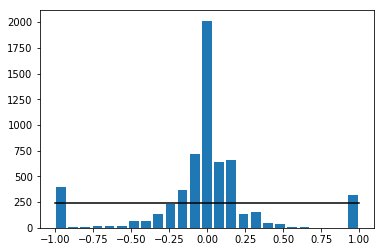

In [5]:
# print a histogram to see which steering angle ranges are most overrepresented
a_angles = a[:,3].astype(np.float)
num_bins = 25
avg_samples_per_bin = len(a)/num_bins
hist, bins = np.histogram(a_angles, num_bins)
width = 0.8 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(a_angles), np.max(a_angles)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')

hist = np.concatenate((hist, [1]))  # because no of bins are 26 (0 to 25), but no of hist were 25.(see print(bins, hist) below)
print(bins, hist)

In [6]:
#http://stackoverflow.com/questions/14947909/python-checking-to-which-bin-a-value-belongs/14947961
# Which angle belongs to which bin......
my_list = a_angles  # list of angles
digitized = np.digitize(my_list,bins)  # for list of angles
x = 51
print(my_list[x], digitized[x], bins[digitized[x]], bins[12], hist[12], avg_samples_per_bin * 0.5)

0.0 13 0.04 -0.04 2014 121.4


In [7]:
digitized = np.digitize(1.0,bins)-1   # for single angle
digitized
print(digitized, bins[digitized], hist[digitized])

25 1.0 1


In [8]:
car_images = []
steering_angles = []

threshold = avg_samples_per_bin * 0.5

'''
for i in range(bins):
    if hist[i] < threshold:
        keep_probs.append(1.)
    else:
        keep_probs.append(1./(hist[i]/threshold))
'''
    
def Augmentation(row):
    
    steering_center = float(row[3])
    digitized_center = np.digitize(steering_center,bins)-1   #bin number for steering_center angle for this row
    
    # create adjusted steering measurements for the side camera images
    correction = 0.20     # this is a parameter to tune
    steering_left = steering_center + correction
    steering_right = steering_center - correction
    
    digitized_left = np.digitize(steering_left,bins)-1    #bin number for steering_left angle for this row
    digitized_right = np.digitize(steering_right,bins)-1   #bin number for steering_right angle for this row
    
    select_prob = np.random.random()
    
    # read in images from center, left and right cameras
    path = 'data/data/' # fill in the path to your training IMG directory
    
    
    
    # It balances histogram, if image is in the bin having no of images greater than threshold ....(see above 2 cells)
    #1./(hist[digitized_center]/threshold) is equivalent to  threshold/hist[digitized_center] (i.e 100/500 = 0.2 = keep_probs)
    if hist[digitized_center] > threshold:   #hist[digitized_center] will give no of images in that bin
        keep_probs_center = 1./(hist[digitized_center]/threshold)
    else:
        keep_probs_center = 1
    if select_prob > (1-keep_probs_center):
        img_center =  np.asarray(Image.open(path+row[0]))
        img_center_flipped = np.fliplr(img_center)
        car_images.append(img_center)
        car_images.append(img_center_flipped)
        steering_angles.append(steering_center)
        steering_angles.append(-steering_center)
        
    if hist[digitized_left] > threshold:
        keep_probs_left = 1./(hist[digitized_left]/threshold)
    else:
        keep_probs_left = 1
    if select_prob > (1-keep_probs_left)  and steering_left<0.99:
        img_left =  np.asarray(Image.open(path+row[1]))
        img_left_flipped = np.fliplr(img_left)
        car_images.append(img_left)
        car_images.append(img_left_flipped)
        steering_angles.append(steering_left)
        steering_angles.append(-steering_left)
        
    if hist[digitized_right] > threshold:
        keep_probs_right = 1./(hist[digitized_right]/threshold)
    else:
        keep_probs_right = 1
    if select_prob > (1-keep_probs_right)  and steering_right>-0.99:
        img_right =  np.asarray(Image.open(path + row[2]))
        img_right_flipped = np.fliplr(img_right)
        car_images.append(img_right)
        car_images.append(img_right_flipped)
        steering_angles.append(steering_right)
        steering_angles.append(-steering_right)
        
        
    #print(car_images[1].shape,steering_angles)

In [10]:
global car_images
global steering_angles

for row in samples:
    Augmentation(row)
    #threshold = avg_samples_per_bin * 0.5
    #if len(steering_angles)%5000==0:
        #avg_samples_per_bin = len(steering_angles)/num_bins

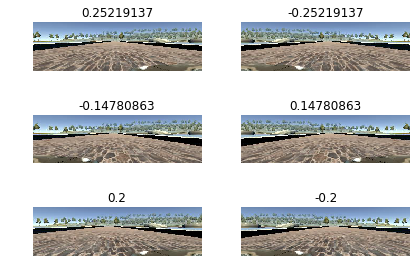

In [11]:
#Sample example

#Augmentation(a[300])
for i in range(100,106):
    image = car_images[i]
    plt.subplot(3, 2, i-99)  # we want i = 1 to 6 , so 100-99
    plt.tight_layout()
    #print(steering_angles[i])
    plt.imshow(image, aspect='auto')
    plt.title(steering_angles[i])
    plt.axis('off')

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ] [ 536   27 1466  113  229  380  836 1612 2182 7044 1150  952  680  952 1150
 7044 2182 1612  836  380  229  113 1466   27  536    1]


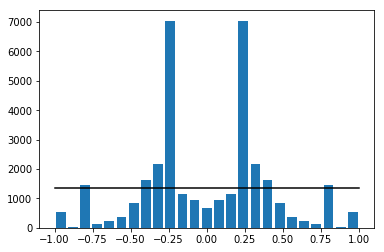

In [12]:
# print a histogram to see which steering angle ranges are most overrepresented
b_angles = steering_angles
num_bins = 25
avg_samples_per_bin = len(steering_angles)/num_bins
hist, bins = np.histogram(b_angles, num_bins)
width = 0.8 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(b_angles), np.max(b_angles)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')

hist = np.concatenate((hist, [1]))  # because no of bins are 26 (0 to 25), but no of hist were 25.(see print(bins, hist) below)
print(bins, hist)

In [13]:
print(len(car_images),len(steering_angles))

train_images, validation_images, train_angles, Validation_angles  = train_test_split(car_images,steering_angles, test_size=0.2)
print (len(car_images), len(train_images), len(validation_images), len(train_angles), len(Validation_angles))

33734 33734
33734 26987 6747 26987 6747


In [ ]:
#car_images = []
#steering_angles = []
i=0

def process_image(image):
    
    shape = image.shape
    # note: numpy arrays are (row, col)!
    image = image[math.floor(shape[0]/4):shape[0]-25, 0:shape[1]]
    image = cv2.resize(image, (64, 64))
    
    #image2 = np.zeros(image.shape, dtype='u1')
    #image2 = brightness_process_image(image, image2)
    
    return image

In [ ]:
#Sample processing on first image in csv file
path = 'data/data/' # fill in the path to your training IMG directory

divider = np.asarray(np.zeros((64,10,3), dtype='u1'))

#img_center1 = process_image(np.asarray(Image.open(path+csvlines[550][0:38]))) #line[x][0:38], x is row number, [0:38] is characters of first coulmn of that row..
img_center1 = process_image(np.asarray(Image.open(path+samples[250][0])))  #line[x][1], x is row number, [0] is 0th coulmn of that row..
print(img_center1.shape, divider.shape)
img_center1_flipped = np.fliplr(img_center1)
res1 = np.hstack((img_center1, divider, img_center1_flipped))
plt.imshow(res1)


In [ ]:
def generator(images_samples, angles_samples, batch_size=32):
    num_samples = int(len(images_samples)*0.3)   # will take 30% of the images
    while 1: # Loop forever so the generator never terminates
        
        shuffle(images_samples,angles_samples)    #images shuffled
        
        for offset in range(0, num_samples, batch_size):    #every epoch we ll have shuffled 30% images
            batch_samples = images_samples[offset:offset+batch_size]
            batch_angles = angles_samples[offset:offset+batch_size]
            
            generator_images = []
            generator_angles = []
            
            for image1 in batch_samples:
                processed_img = process_image(image1)
                generator_images.append(processed_img)
                #generator_angles.append(angle2)
            
            for angle1 in batch_angles:
                generator_angles.append(angle1)
            
            X_train = np.array(generator_images)
            y_train = np.array(batch_angles)
            #print(X_train.shape, y_train.shape)
            yield sklearn.utils.shuffle(X_train, y_train)

In [ ]:
# compile and train the model using the generator function
train_generator = generator(train_images, train_angles, batch_size=32)
validation_generator = generator(validation_images, Validation_angles, batch_size=32)

In [ ]:
model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(64,64,3)))
# layer 1 output shape is 32x32x32
model.add(Convolution2D(32, 5, 5, input_shape=(64, 64, 3), subsample=(2, 2), border_mode="same"))
model.add(ELU())
# layer 2 output shape is 15x15x16
model.add(Convolution2D(16, 3, 3, subsample=(1, 1), border_mode="valid"))
model.add(ELU())
model.add(Dropout(.4))
model.add(MaxPooling2D((2, 2), border_mode='valid'))
# layer 3 output shape is 12x12x16
model.add(Convolution2D(16, 3, 3, subsample=(1, 1), border_mode="valid"))
model.add(ELU())
model.add(Dropout(.4))
# Flatten the output
model.add(Flatten())
# layer 4
model.add(Dense(1024))
model.add(Dropout(.3))
model.add(ELU())
# layer 5
model.add(Dense(512))
model.add(ELU())
# Finally a single output, since this is a regression problem
model.add(Dense(1))

In [ ]:
model.compile(loss='mse', optimizer='adam')
#model.fit(X_train, y_train,validation_split=0.2, shuffle=True, nb_epoch=7)
model.fit_generator(train_generator, samples_per_epoch= \
            len(train_images)*6*0.3, validation_data=validation_generator, \
            nb_val_samples=len(validation_images)*6*0.3, nb_epoch=7)         #https://keras.io/models/sequential/#fit_generator

model.save('model_test.h5')